In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import utils as ut
import m_models as mm
import os
from tqdm import tqdm_notebook as tqdm

import pylab

import statsmodels.api as sm

import scipy.stats as sps
from scipy.optimize import minimize_scalar as minimize_scalar

import pickle

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']= 36
plt.rcParams['axes.labelsize']= 40
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

In [3]:
name = 'diabetes'

In [4]:
X, y = ut.DataLoader(name=name)
X, y = ut.preprocess(X, y)

In [5]:
real_data = mm.ALC(X, y, progress_bar=lambda x: tqdm(x, leave = False))

In [6]:
statmodel = ut.define_model(y)

In [7]:
sample_size = np.arange(10, 500, 5)
print(X.shape)

(442, 5)


In [8]:
def aDistribution(cov, alpha=0.05):
    
    W = sps.multivariate_normal(mean=np.zeros(cov.shape[0]), cov = cov).rvs(size=1000)

    function = lambda r: (((W ** 2).sum(axis=1) > r ** 2).mean() - alpha) ** 2

    res = minimize_scalar(function, method='Golden')['x']
    return res

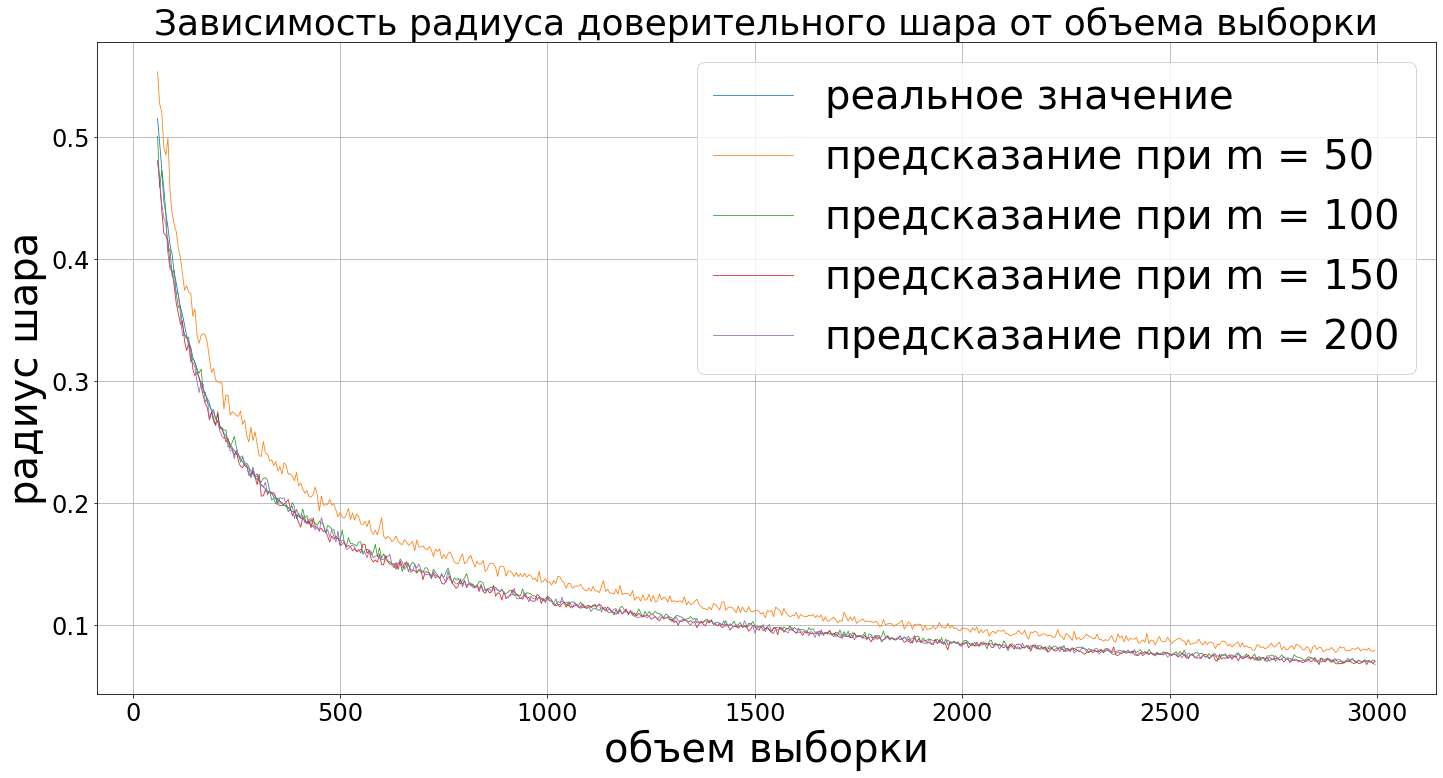

In [9]:
num_iters = 1000

r = 10

sample_sizes = np.arange(10, 3000, 5)  

plt.plot(real_data['m'][r:], real_data['E'][r:], lw = 0.8, label='реальное значение')
plt.title('Зависимость радиуса доверительного шара от объема выборки')

for m in [50, 100, 150, 200]:
    
    X_m, y_m = ut.get_subset(X, y, m, duplications=False)
    w_hat = ut.get_params(X_m, y_m)
    
    answers = []
    
    for i in tqdm(range(num_iters)):
        X_sub, y_sub = ut.get_subset(X_m, y_m, m // 2, duplications=False)
        model = statmodel(y_sub, X_sub)
        w_hat = ut.get_params(X_sub, y_sub)
        answers.append((-model.hessian_fixed(w_hat) / X_sub.shape[0]))
    
    answers = np.asarray(answers)
    
    i_matrix = np.linalg.inv(np.mean(answers, axis = 0))
      
    rs = []

    for cur_m in tqdm(sample_sizes):
        rs.append(aDistribution(i_matrix / cur_m))
    
    rs = np.asarray(rs)
    
    plt.plot(sample_sizes[r:], rs[r:], lw = 0.8, label='предсказание при m = {}'.format(m))

plt.xlabel('объем выборки')
plt.ylabel('радиус шара')
plt.grid()
plt.legend()
plt.show()

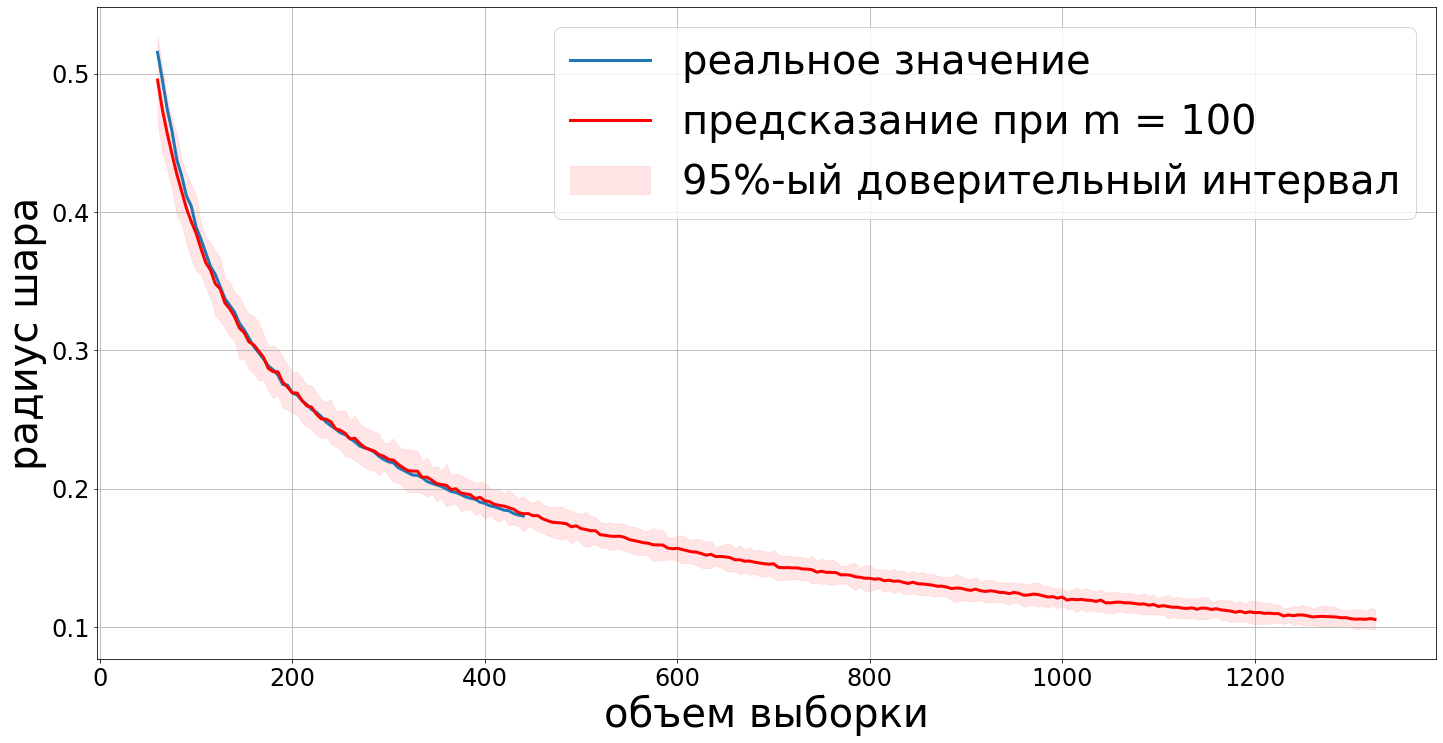

In [10]:
m = 100
r = 10

sample_sizes = np.arange(10, 3 * X.shape[0], 5)  

many_rs = []

plt.plot(real_data['m'][r:], real_data['E'][r:], label='реальное значение')
#plt.title('Зависимость радиуса доверительного шара от объема выборки')

for i in range(20):
    
    X_m, y_m = ut.get_subset(X, y, m, duplications=False)
    w_hat = ut.get_params(X_m, y_m)
    
    answers = []
    
    for i in range(num_iters):
        X_sub, y_sub = ut.get_subset(X_m, y_m, m // 2, duplications=False)
        model = statmodel(y_sub, X_sub)
        w_hat = ut.get_params(X_sub, y_sub)
        answers.append((-model.hessian_fixed(w_hat) / X_sub.shape[0]))
    
    answers = np.asarray(answers)
    
    i_matrix = np.linalg.inv(np.mean(answers, axis = 0))
    
    rs = []

    for cur_m in sample_sizes:
        rs.append(aDistribution(i_matrix / cur_m))
    
    rs = np.asarray(rs)
    many_rs.append(rs)

many_rs = np.asarray(many_rs)

alpha = 0.95

left_q = sps.norm(loc=many_rs.mean(axis=0)[r:], scale=many_rs.std(axis=0)[r:]).ppf((1 - alpha) / 2)
right_q = sps.norm(loc=many_rs.mean(axis=0)[r:], scale=many_rs.std(axis=0)[r:]).ppf(1 - (1 - alpha) / 2)

plt.plot(sample_sizes[r:], many_rs.mean(axis=0)[r:], color='red', label='предсказание при m = {}'.format(m))
plt.fill_between(sample_sizes[r:], left_q,right_q, 
                 color='red', lw=0.7, alpha=0.1, label='95%-ый доверительный интервал')

plt.xlabel('объем выборки')
plt.ylabel('радиус шара')
plt.legend()
plt.grid()
#plt.savefig('../data/pics/ALC_modified_{}.pdf'.format(name), format='pdf')
plt.show()

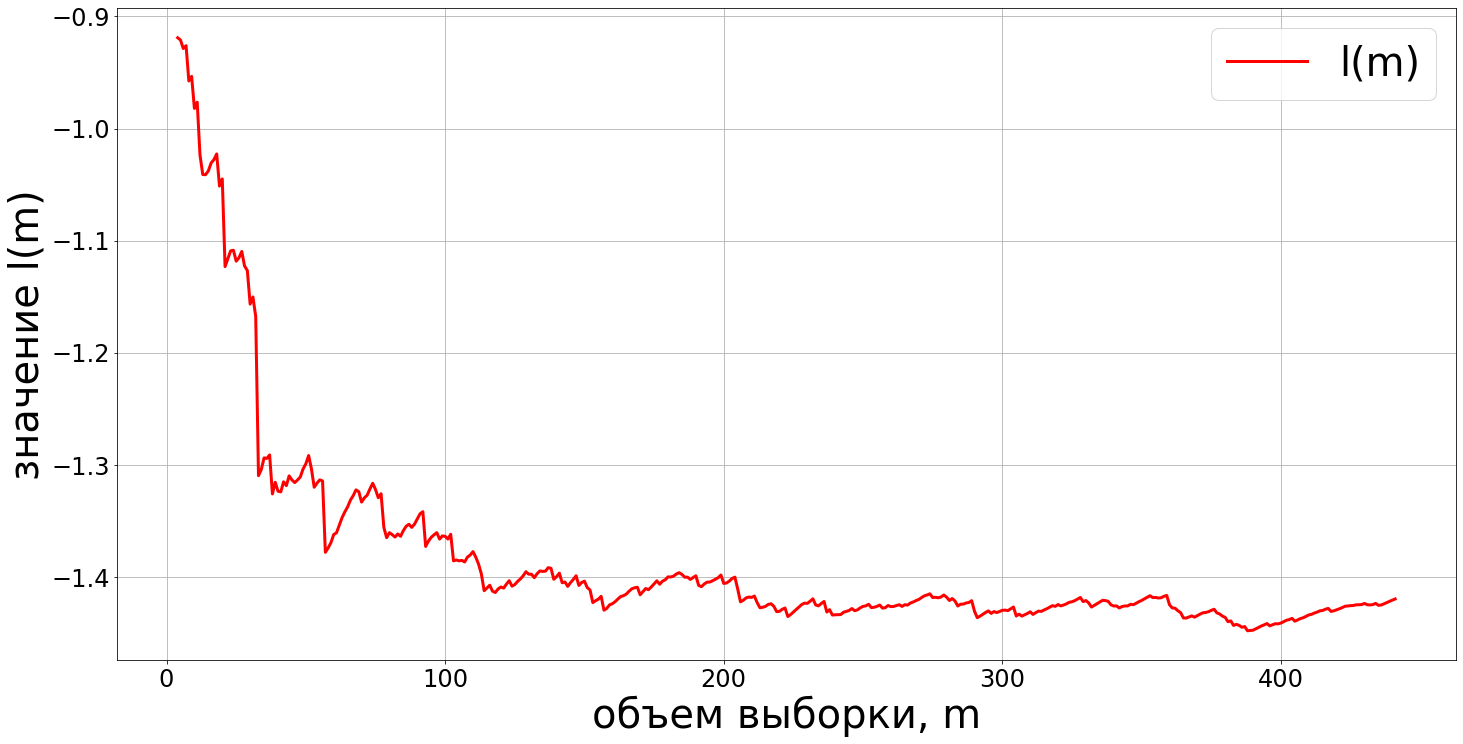

In [13]:
l = []

for m in tqdm(range(4, X.shape[0])):
    
    X_m, y_m = X[:m], y[:m]
    w_hat = ut.get_params(X_m, y_m)
    
    l.append(np.mean([sps.norm(loc=X @ w_hat, scale=1).logpdf(y) for X, y in zip(X_m, y_m)]))
    
plt.plot(np.arange(4, X.shape[0]), l, color='red', label='l(m)')

plt.xlabel('объем выборки, m')
plt.ylabel('значение l(m)')
plt.legend()
plt.grid()
#plt.savefig('../data/pics/ALC_modified_{}.pdf'.format(name), format='pdf')
plt.show()

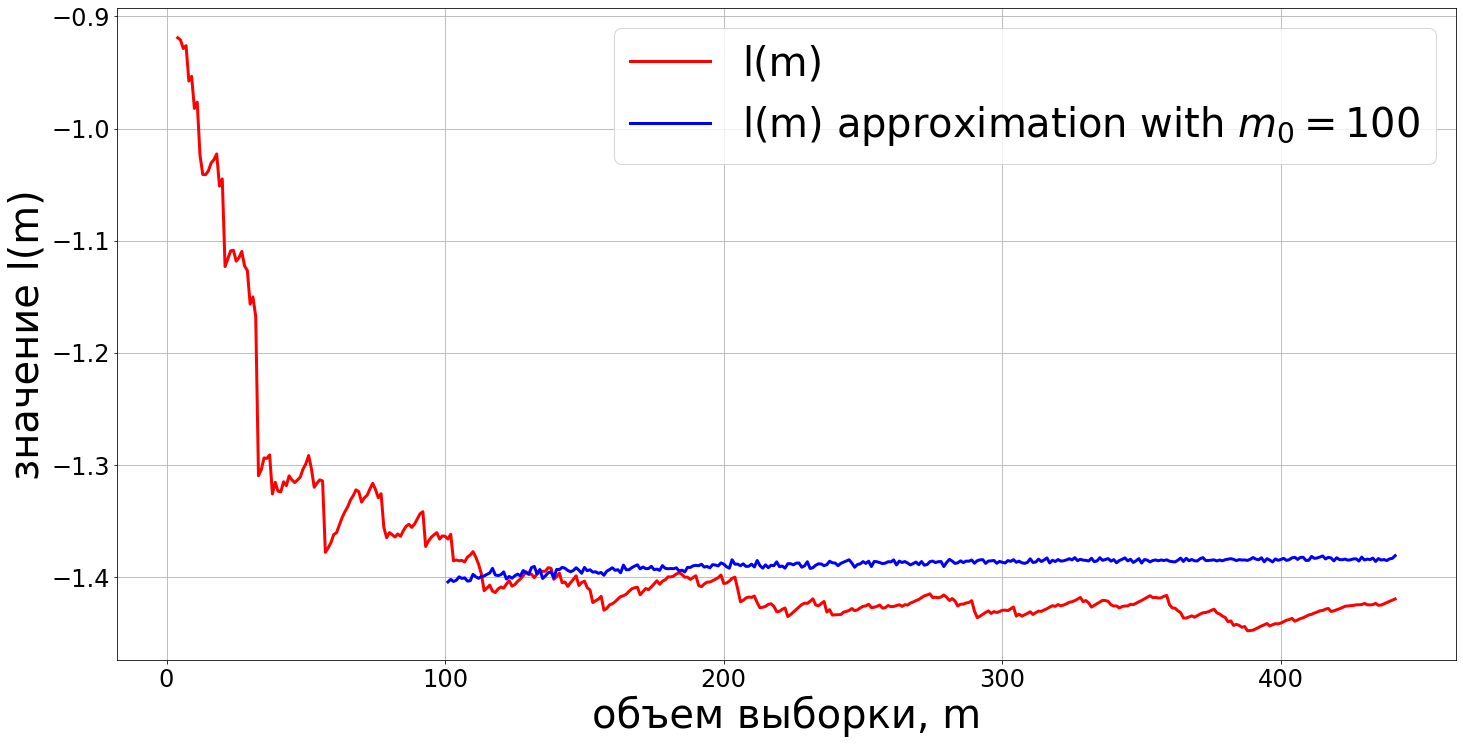

In [18]:
m_0 = 100

X_m_0, y_m_0 = X[:m_0], y[:m_0]
w_hat = ut.get_params(X_m_0, y_m_0)

num_iters = 1000

answers = []

for i in range(num_iters):
    X_sub, y_sub = ut.get_subset(X_m_0, y_m_0, m_0 // 2, duplications=False)
    model = statmodel(y_sub, X_sub)
    w_hat = ut.get_params(X_sub, y_sub)
    answers.append((-model.hessian_fixed(w_hat) / X_sub.shape[0]))

answers = np.asarray(answers)

i_matrix = np.linalg.inv(np.mean(answers, axis=0))

approx_l = []

for m in tqdm(range(m_0 + 1, X.shape[0])):

    cur_l = []

    for i in range(50):
        w_hat_cur = sps.multivariate_normal(mean=w_hat, cov=i_matrix / m).rvs(size=1)
        cur_l.append(np.mean([sps.norm(loc=X @ w_hat_cur, scale=1).logpdf(y) for X, y in zip(X_m_0, y_m_0)]))

    approx_l.append(np.mean(cur_l))
    
plt.plot(np.arange(4, X.shape[0]), l, color='red', label='l(m)')
plt.plot(np.arange(m_0 + 1, X.shape[0]), approx_l, color='blue', label='l(m) approximation with $m_0=100$')

plt.xlabel('объем выборки, m')
plt.ylabel('значение l(m)')
plt.legend()
plt.grid()
plt.show()

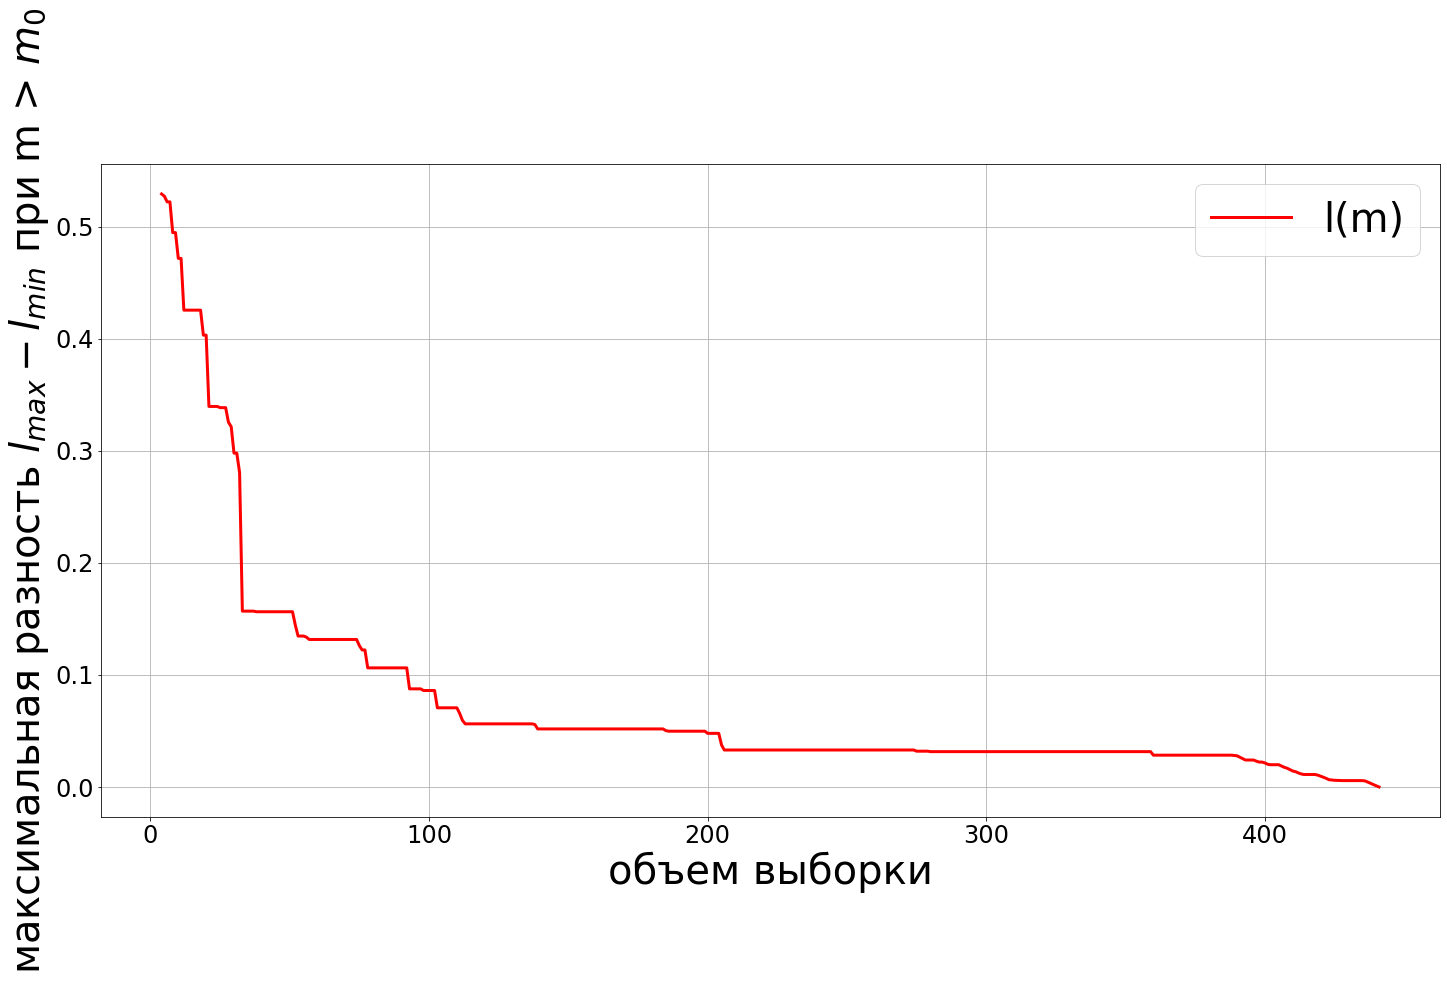

In [12]:
l_diff = []
for i in range(0, len(l)):
    l_diff.append(np.max(l[i:]) - np.min(l[i:]))
    
plt.plot(np.arange(4, X.shape[0]), l_diff, color='red', label='l(m)')

plt.xlabel('объем выборки')
plt.ylabel('максимальная разность $l_{max} - l_{min}$ при m > $m_0$')
plt.legend()
plt.grid()
#plt.savefig('../data/pics/ALC_modified_{}.pdf'.format(name), format='pdf')
plt.show()

In [ ]:
# m_opt = []
eps = 0.05

m_opt = list(m_opt)

m_0_max = 100

for m_0 in tqdm(range(4 + 55, m_0_max + 1)):
    X_m_0, y_m_0 = X[:m_0], y[:m_0]
    w_hat = ut.get_params(X_m_0, y_m_0)

    num_iters = 1000

    answers = []

    for i in range(num_iters):
        X_sub, y_sub = ut.get_subset(X_m_0, y_m_0, m_0 // 2, duplications=False)
        model = statmodel(y_sub, X_sub)
        w_hat = ut.get_params(X_sub, y_sub)
        answers.append((-model.hessian_fixed(w_hat) / X_sub.shape[0]))

    answers = np.asarray(answers)

    i_matrix = np.linalg.inv(np.mean(answers, axis=0))

    approx_l = []

    for m in tqdm(range(m_0 + 1, X.shape[0])):

        cur_l = []

        for i in range(50):
            w_hat_cur = sps.multivariate_normal(mean=w_hat, cov=i_matrix / m).rvs(size=1)
            cur_l.append(np.mean([sps.norm(loc=X @ w_hat_cur, scale=1).logpdf(y) for X, y in zip(X_m_0, y_m_0)]))

        approx_l.append(np.mean(cur_l))
    
    l_diff_approx = []
    for i in range(0, len(approx_l)):
        l_diff_approx.append(np.max(approx_l[i:]) - np.min(approx_l[i:]))
        
    l_diff_approx = np.asarray(l_diff_approx)
        
    m_opt.append(m_0 + 1 + np.argmax((l_diff_approx < eps)))

In [30]:
pd.DataFrame(data=m_opt, columns=['m_opt']).to_csv('m_opt.csv')

In [14]:
m_opt = pd.read_csv('m_opt.csv')['m_opt'].to_numpy()

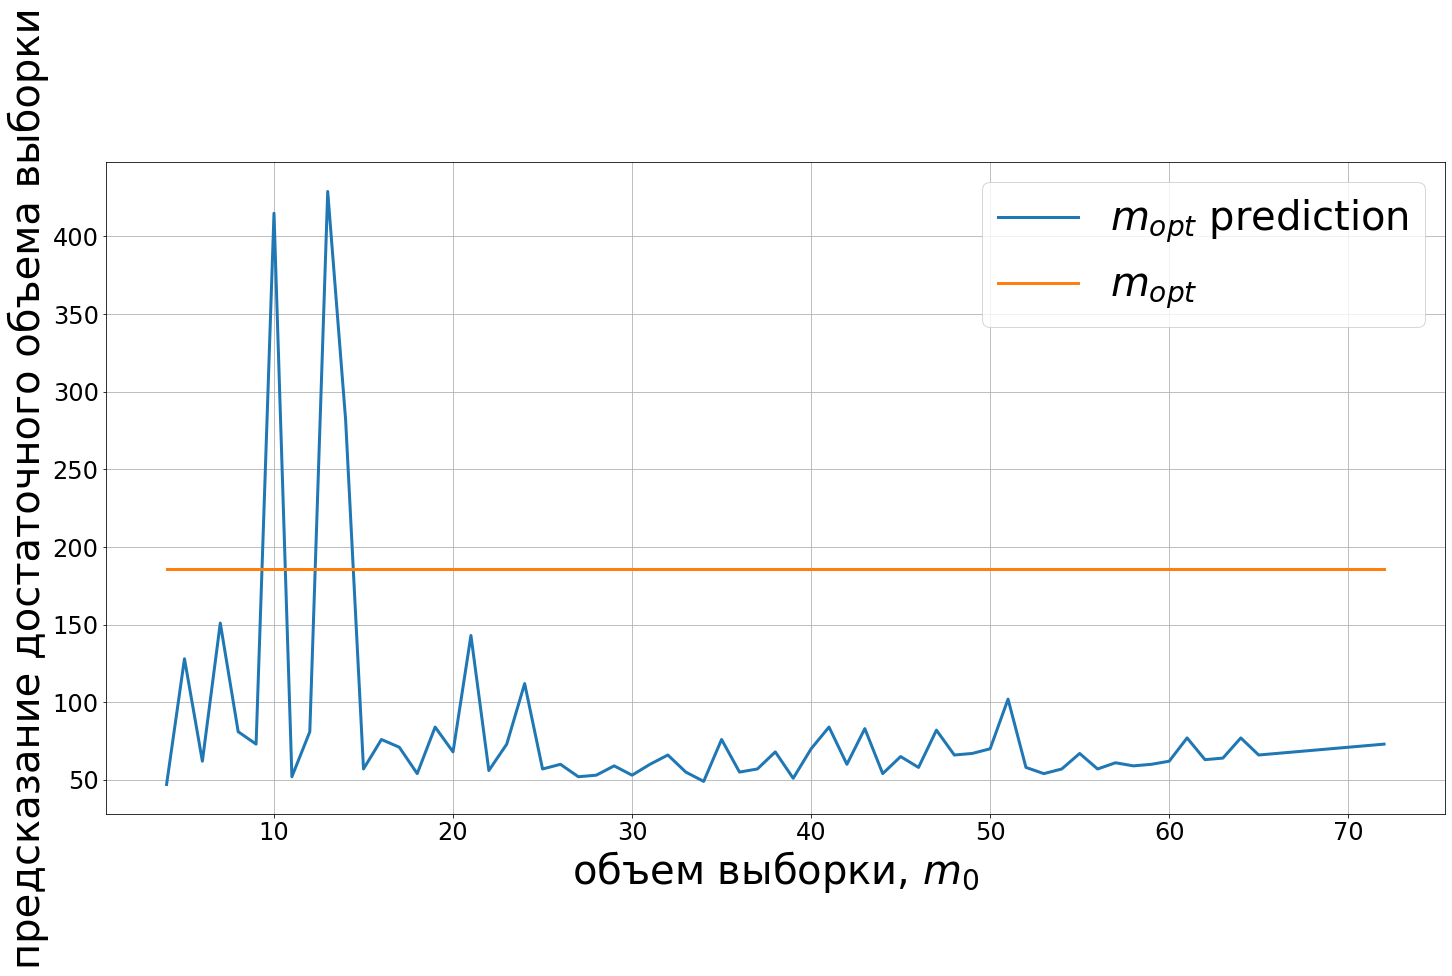

In [19]:
plt.plot(np.arange(4, 4 + 69), m_opt, label='$m_{opt}$ prediction')
plt.plot(np.arange(4, 4 + 69), np.zeros(69) + 4 + np.argmax(np.array(l_diff) < eps), label='$m_{opt}$')

plt.xlabel('объем выборки, $m_0$')
plt.ylabel('предсказание достаточного объема выборки')
plt.legend()
plt.grid()
#plt.savefig('../data/pics/ALC_modified_{}.pdf'.format(name), format='pdf')
plt.show()

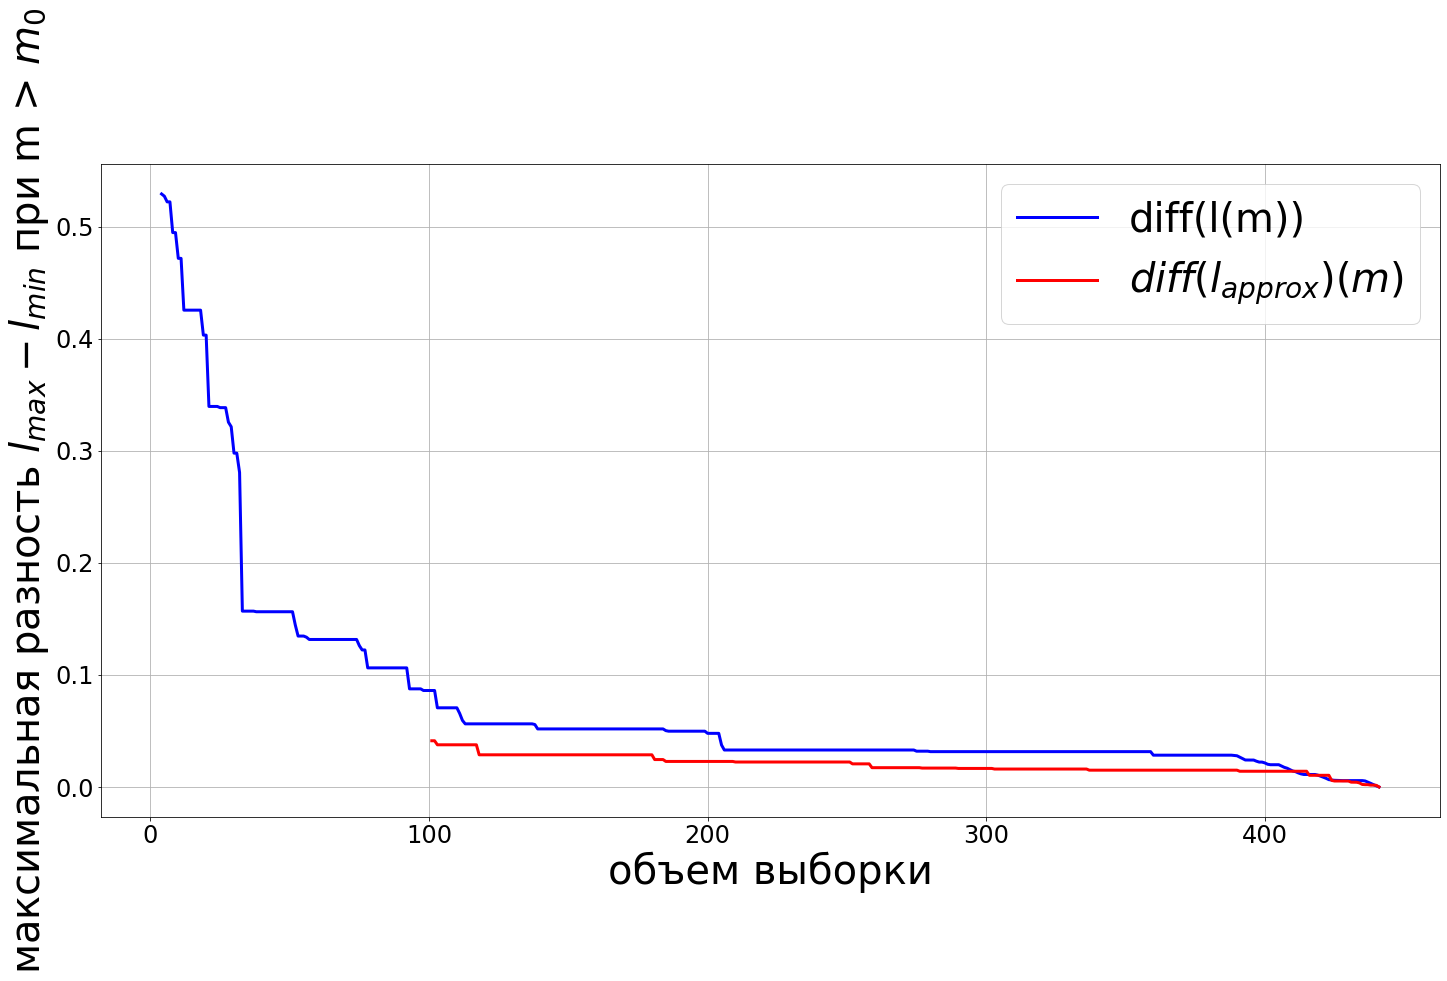

In [63]:
l_diff_approx = []
for i in range(0, len(approx_l)):
    l_diff_approx.append(np.max(approx_l[i:]) - np.min(approx_l[i:]))
    
plt.plot(np.arange(4, X.shape[0]), l_diff, color='blue', label='diff(l(m))')
plt.plot(np.arange(m_0 + 1, X.shape[0]), l_diff_approx, color='red', label='$diff(l_{approx})(m)$')

plt.xlabel('объем выборки')
plt.ylabel('максимальная разность $l_{max} - l_{min}$ при m > $m_0$')
plt.legend()
plt.grid()
#plt.savefig('../data/pics/ALC_modified_{}.pdf'.format(name), format='pdf')
plt.show()

In [47]:
approx_l

[-1.4150421138771594,
 -1.4037310258183764,
 -1.3923002939077715,
 -1.4130897466320758,
 -1.3916874456224335,
 -1.3982816334047654,
 -1.3988737482281082,
 -1.3939575474129098,
 -1.405645466937325,
 -1.4095444432763173,
 -1.3998778200920239,
 -1.39170204745388,
 -1.3852771225597271,
 -1.3973194505545257,
 -1.3953000771719946,
 -1.3856244906928095,
 -1.4024371621101883,
 -1.4061781704141743,
 -1.386150515078991,
 -1.3867959668631484,
 -1.3938886992315023,
 -1.3954551255148393,
 -1.3896058418816093,
 -1.3883239898456898,
 -1.3867688896251122,
 -1.386802685189027,
 -1.394949310727608,
 -1.3834344453857719,
 -1.3849181788146394,
 -1.3905227826012327,
 -1.3757854834746588,
 -1.3830323138377019,
 -1.3797815407600404,
 -1.3883395340623965,
 -1.3816541741665531,
 -1.3797207197275327,
 -1.3885237229195528,
 -1.3853826188869538,
 -1.3829943548351065,
 -1.3890456282562442,
 -1.388346870706308,
 -1.3861354991629824,
 -1.3729393950994129,
 -1.390544412205265,
 -1.3855192396993983,
 -1.38039417526445